# **TASK 2:** Brain Tumor Classification





## Dataset preparation

In [ ]:
# get dataset
!wget https://figshare.com/ndownloader/articles/1512427/versions/5

--2022-03-23 10:54:11--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 63.33.233.118, 34.241.64.37, 2a05:d018:1f4:d000:b61c:528f:7f9e:e5a, ...
Connecting to figshare.com (figshare.com)|63.33.233.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  30.2MB/s    in 30s     

2022-03-23 10:54:41 (28.2 MB/s) - ‘5’ saved [879501695/879501695]



In [ ]:
# unzip
!unzip /content/5

Archive:  /content/5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [ ]:
# extract individual dataset
!mkidr BrainTumor

!unzip brainTumorDataPublic_1-766.zip -d BrainTumor
!unzip brainTumorDataPublic_1533-2298.zip -d BrainTumor
!unzip brainTumorDataPublic_767-1532.zip -d BrainTumor
!unzip brainTumorDataPublic_2299-3064.zip -d BrainTumor

This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images
from 233 patients

In [ ]:
# check length

dataset = sorted(glob("/content/BrainTumor/*"".mat"))


print(f"number of datasets: {len(dataset)}")

number of datasets: 3064


The data is organized in matlab data format (.mat file). Each file stores a struct.

containing the following fields for an image:

* cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor

* cjdata.PID: patient ID

* cjdata.image: image data

* cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.

* cjdata.tumorMask: a binary image with 1s indicating tumor region


In [ ]:
# Requirements
import os
import h5py
import random
import albumentations as A
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from PIL import Image
from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# set the random seeds
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)
os.environ['CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)

In [ ]:
def get_data(mat_file):
  """
  Extracts image, mask, label for given mat_file

  Args:
    mat_file: .mat file path

  Returns:
    image: numpy image array
    mask: numpy mask array
    label: classification label integer
  """

  f = h5py.File(mat_file, "r")

  # get image
  image = np.array(f[list(f.keys())[0]]['image'], dtype="uint16")

  # get mask
  mask = np.array(f[list(f.keys())[0]]['tumorMask'], dtype="uint16")

  # get label
  label = np.array(f[list(f.keys())[0]]['label'], dtype="int")[0][0]

  f.close()

  return image, mask, label

In [ ]:
# create directory to save images
!mkdir BrainTumorImages

for mat in tqdm(dataset):
  # extract data from mat file
  image, mask, label = get_data(mat)

  # image_id to save
  image_id = mat.split("/")[-1].split(".")[0]

  # save in grayscale
  # image
  plt.imsave(f"/content/BrainTumorImages/{image_id}_image_{label}.jpg", image, cmap="binary_r")

  # mask
  plt.imsave(f"/content/BrainTumorImages/{image_id}_mask_{label}.jpg", mask, cmap="binary_r")


mkdir: cannot create directory ‘BrainTumorImages’: File exists


  0%|          | 0/3064 [00:00<?, ?it/s]

In [ ]:
image_dataset = (sorted(glob("/content/BrainTumorImages/*""*_image*")))

print(f"number of datasets: {len(dataset)}")

number of datasets: 3064


In [ ]:
# copy to drive for future use
!cp -R /content/BrainTumorImages /content/drive/MyDrive/BrainsightAI/Data/

The dataset is collected from 233 patients with three kinds of brain tumor: 

* meningioma: 708 slices

* glioma: 1426 slices

* pituitary: 930 slices

In [ ]:
# check each class 
meningioma_ds = sorted(glob("/content/BrainTumorImages/*""*_image_1.jpg")) # 1
glioma_ds = sorted(glob("/content/BrainTumorImages/*""*_image_2.jpg")) # 2
pituitary_ds = sorted(glob("/content/BrainTumorImages/*""*_image_3.jpg")) # 3

# count classes
print(f"number of meningioma: {len(meningioma_ds)}\n")
print(f"number of glioma: {len(glioma_ds)}\n")
print(f"number of pituitary: {len(pituitary_ds)}")

number of meningioma: 708

number of glioma: 1426

number of pituitary: 930


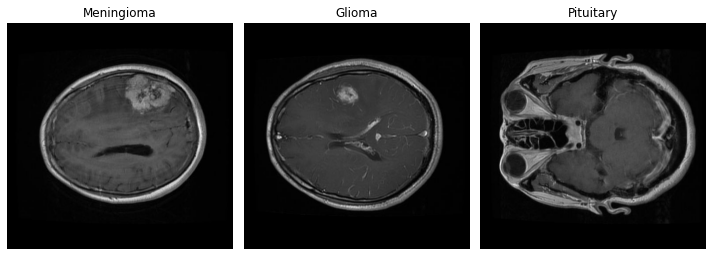

In [ ]:
# subplot

# subplot for each class

# generate random interger to read the image
# taking 708 has lowest limit which is of meningioma to avoid index error
random_image_id = np.random.randint(0, 708) 

# read images
meningioma_img = plt.imread(meningioma_ds[random_image_id])
glioma_img = plt.imread(glioma_ds[random_image_id])
pituitary_img = plt.imread(pituitary_ds[random_image_id])


fig = plt.figure(figsize=(10, 10))         
plt.subplot(1, 3, 1)
plt.title("Meningioma")
plt.imshow(meningioma_img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Glioma")
plt.imshow(glioma_img)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Pituitary")
plt.imshow(pituitary_img)
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# gather datasets
image_dataset = (sorted(glob("/content/BrainTumorImages/*""*_image*")))
mask_dataset = (sorted(glob("/content/BrainTumorImages/*""*_mask*")))

assert (len(image_dataset) == len(mask_dataset))

In [ ]:
def get_label(path):
  """
  extract the label from the image path
  Args:
    path: image path string
  Returns:
    label: label in int
  """
  image_id = path.split("/")[-1]
  label = int(image_id.split(".")[0].split("_")[-1])
  label = label - 1

  return label

In [ ]:
# save in DataFrame

df = pd.DataFrame({"image_path": image_dataset,
                   "mask_path": mask_dataset})

df.head(3)

,image_path,mask_path
0,/content/BrainTumorImages/1000_image_3.jpg,/content/BrainTumorImages/1000_mask_3.jpg
1,/content/BrainTumorImages/1001_image_3.jpg,/content/BrainTumorImages/1001_mask_3.jpg
2,/content/BrainTumorImages/1002_image_3.jpg,/content/BrainTumorImages/1002_mask_3.jpg


In [ ]:
# get labels
df['label'] = df['image_path'].apply(get_label)

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)

df.head(3)

,image_path,mask_path,label
0,/content/BrainTumorImages/394_image_1.jpg,/content/BrainTumorImages/394_mask_1.jpg,0
1,/content/BrainTumorImages/748_image_2.jpg,/content/BrainTumorImages/748_mask_2.jpg,1
2,/content/BrainTumorImages/2890_image_2.jpg,/content/BrainTumorImages/2890_mask_2.jpg,1


In [ ]:
# recheck the labels
print(df['label'].value_counts())

1    1426
2     930
0     708
Name: label, dtype: int64


### Train Validation Test Split

In [ ]:
# train valid test split

## split train test data
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 0].values, 
                                                    df.iloc[:, 2].values, stratify=df.iloc[:, 2].values, test_size=0.3)

## split valid and test data
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, stratify=y_test, test_size=0.35)

In [ ]:
# saving data to csv

# train set
pd.DataFrame({"image_path": x_train, "label": y_train}).to_csv("/content/drive/MyDrive/BrainsightAI/Data/dfTumor_train.csv", index=False)

# test set
pd.DataFrame({"image_path": x_test, "label": y_test}).to_csv("/content/drive/MyDrive/BrainsightAI/Data/dfTumor_test.csv", index=False)

# valid set
pd.DataFrame({"image_path": x_valid, "label": y_valid}).to_csv("/content/drive/MyDrive/BrainsightAI/Data/dfTumor_valid.csv", index=False)

In [ ]:
# load train valid test data

train_df = pd.read_csv("/content/drive/MyDrive/BrainsightAI/Data/dfTumor_train.csv")

valid_df = pd.read_csv("/content/drive/MyDrive/BrainsightAI/Data/dfTumor_valid.csv")

test_df = pd.read_csv("/content/drive/MyDrive/BrainsightAI/Data/dfTumor_test.csv")

# check size
len(train_df), len(valid_df), len(test_df)

(2144, 598, 322)

In [ ]:
# copy saved images to colab VM
!cp -R /content/drive/MyDrive/BrainsightAI/Data/BrainTumorImages .

### DataGenerator

In [ ]:
# data generator

class DataGenerator():
  def __init__(self, df, batch_size, balance=True, mask=False, augmentation=False, preprocessing=None):
    """
    DataGenerator to generator to number of samples for given batch size.

    The DataGenerator is tweaked generator that generates the uniform number 
    of samples for given batch by passing argument balance. 
    It oversamples the data by duplicating.

    Mask parameter takes advantage of mask given in dataset, by adding it as
    dimension.

    Hardcoded for given dataset

    Args:
      df: dataframe containing images paths
      batch_size: number of samples to generator for each iteration.
      balance: if True generates a balanced data distribution.
      mask: if True adds mask to input image dimension.
      augmentation: if True applies augementation to image.
      preprocessing: preprocessing function to perform any perprocessing default is None

    Returns:
      DataGenerator generator
    """

    self.df = df
    self.batch_size = batch_size
    self.balance = balance
    self.mask = mask
    self.augementation = augmentation
    self.preprocessing = preprocessing
    self.num_class = 3
    self.length = len(self.df)
    if self.augementation:
      self.transform = A.Compose([
                  A.HorizontalFlip(p=0.7),
                  A.VerticalFlip(p=0.7),
                  A.RandomRotate90(p=0.7),
                  A.ElasticTransform(p=0.2, alpha=0.4, sigma=15.55, alpha_affine=5.5),
                  A.GridDistortion(p=0.2, num_steps=4, distort_limit=(-0.2, 0.2)),
                  A.OpticalDistortion(p=0.2, distort_limit=(-0.2, 0.2), shift_limit=(-0.1, 0.1)),
                  A.OneOf([
                           A.RandomBrightness(p=0.5, limit=(-0.2, 0.2)),
                           A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
                           A.RandomContrast(p=0.5, limit=(-0.2, 0.2)),
                        ])
                  ])
      
  def __iter__(self):
      return self

  def __next__(self):

    if not self.balance:
      # get data
      x, y = self.__getdata(self.df, self.batch_size)

    else:
      # get labels
      labels = np.arange(self.num_class, dtype="int")

      # shuffle labels to not always get in same order while collecting the data
      np.random.shuffle(labels)

      # get label respective path
      # the classes mentioned here are different from original class labels
      class_0 = self.df[self.df['label'] == labels[0]]
      class_1 = self.df[self.df['label'] == labels[1]]
      class_2 = self.df[self.df['label'] == labels[2]]

      # number of images per class
      per_batch = self.batch_size // self.num_class

      # remaning number to complete the batch size
      left_over = self.batch_size % self.num_class

      # collect data
      batch_1 = self.__getdata(class_0, per_batch) # class's 0
      batch_2 = self.__getdata(class_1, per_batch) # class's 1
      batch_3 = self.__getdata(class_2, per_batch + left_over) # class's 2

      # stack back 
      x = np.vstack((batch_1[0], batch_2[0], batch_3[0]))
      y = np.vstack((batch_1[1], batch_2[1], batch_3[1]))

    # safety check
    assert x.shape[0] == y.shape[0]

    # shuffle indices again 
    indices = np.random.permutation(x.shape[0])
    x = x[indices]
    y = y[indices]

    return (x, y)

  
  def __getdata(self, paths, batch_size):
    x = []
    y = []

    while len(x) < batch_size:
      # get random image
      random_id = np.random.randint(0, len(paths), 1)[0]

      # get image
      image_path = paths.iloc[random_id, 0]

      # get label
      label = paths.iloc[random_id, 1]

      # read image
      image = Image.open(image_path)

      if self.mask:
        mask_path = image_path.replace("image", "mask")
        mask = Image.open(mask_path)

        if self.preprocessing is not None:
          image = self.preprocessing(image)
          mask = self.preprocessing(mask)

          image = np.asarray(image)
          mask = np.asarray(mask)

        if self.augementation:
          transformed = self.transform(image=image, 
                                        mask=mask)
          image = transformed['image']
          mask = transformed['mask']
      
      else:
        if self.preprocessing is not None:
          image = self.preprocessing(image)
          image = np.asarray(image)
          
        if self.augementation:
          transformed = self.transform(image=image)
          image = transformed['image']

      image = np.expand_dims(image, 0)

      if self.mask:
        mask = np.expand_dims(mask, 0)
        image = np.vstack((image, mask))

      # one hot
      one_hot = to_categorical(label, self.num_class, dtype="int")
      x.append(image.T)
      y.append(one_hot)
    
    assert len(x) ==len(y)

    return (np.asarray(x), np.asarray(y))

### Pipelines 

#### preprocessing

In [ ]:
def preprocessing(image, resize=(224, 224)):
  """
  Applies preprocessing defined

  Args:
    image: PIL image
  Returns:
    preprocessed image
  """

  # convert to BW
  image = image.convert("L")

  # resize
  image = image.resize(resize)

  return image

In [ ]:
# get sample to view
sample_ds = DataGenerator(train_df, 12, True, True, True, preprocessing)
x_samp, y_samp = next(iter(sample_ds))
x_samp.shape, y_samp.shape

((12, 224, 224, 2), (12, 3))

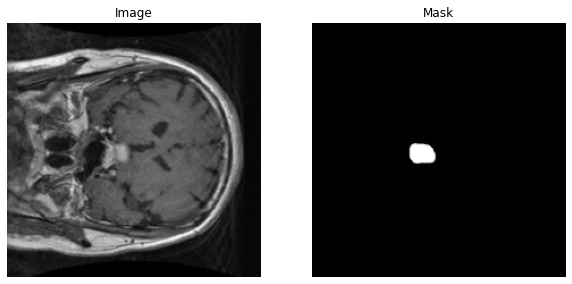

In [ ]:
# random sample view
random_ds = random.choice(x_samp)

fig = plt.figure(figsize=(10, 10))         
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(random_ds[0], cmap="binary_r")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(random_ds[1], cmap="binary_r")
plt.axis("off")
plt.show()

#### input pipeline

In [ ]:
# input pipeline for given image
def pipeline(image, preprocessing, mask=None):
  """
  Input pipeline for prediction
  Args:
    image: image path.
    preprocessing: preprocessing function.
    mask: mask path to use mask as feature map.

  Returns:
    numpy array ready for predictions.
  """

  image = Image.open(image)
  image = preprocessing(image)
  image = np.asarray(image)
  image = np.expand_dims(image, 0)

  if mask is not None:
    mask = Image.open(mask)
    
    mask = preprocessing(mask)

    mask = np.asarray(mask)

    mask = np.expand_dims(mask, 0)
    image = np.vstack((image, mask))

  return image.T

In [ ]:
# test data ready
def test_data(df, pipeline, preprocessing, mask=None):
  """
  Generates the preprocessed model ready dataset for given dataframe

  Args:
    df: dataframe containing paths.
    pipeline: input pipepline
    preprocessing: preprocessing pipeline
    mask: uses mask if give

  Returns:
    x and y arrays
  """

  x = []
  y = []

  for i in range(len(df)):
    # get image
    image_path = df.iloc[i, 0]

    # get label
    label = df.iloc[i, 1]

    mask_path = None
    if mask:
      mask_path = image_path.replace("image", "mask")

    image = pipeline(image_path, preprocessing, mask_path)
    one_hot = to_categorical(label, 3, dtype="int")

    x.append(image)
    y.append(one_hot)

  assert len(x) ==len(y)

  return (np.asarray(x), np.asarray(y))

## Model

### GradCAM
**gradcam for interperting the saliency heatmap instead of older version**

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  """
  Generates heatmap

  Args:
    img_array: image array
    model: model to use
    last_conv_layer_name: conv layer to use
    pred_index: targeted class

  Returns:
    heatmap numpy
  """
  
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def heatmap_to_img(heatmap):
  """
  converts the heatmap into image (array)

  Args:
    heatmap: numpy heatmap
  Returns:
    mask in numpy
  """
  heatmap = np.uint8(255 * heatmap)

  mask = plt.cm.get_cmap("jet")


  mask = mask(np.arange(256))[:, :3]
  mask = mask[heatmap]

  mask = keras.preprocessing.image.array_to_img(mask)
  mask = mask.resize((224, 224))
  mask = keras.preprocessing.image.img_to_array(mask)

  return mask.astype("uint8")

### CNN Model 1

In [ ]:
# mask model
def cnn_mask():
  x = keras.layers.Input((224, 224, 2))

  conv_1 = keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu",padding='same', name="conv_1")(x)
  pool_1 = keras.layers.MaxPool2D(2, name="maxpooling_1")(conv_1)

  conv_2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='same', name="conv_2",)(pool_1)
  pool_2 = keras.layers.MaxPool2D(2, name="maxpooling_2")(conv_2)

  conv_3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same', name="conv_3",)(pool_2)
  pool_3 = keras.layers.MaxPool2D(2, name="maxpooling_3")(conv_3)

  conv_4 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same', name="conv_4",)(pool_3)
  
  flatten = keras.layers.Flatten(name="flatten")(conv_4)

  y = keras.layers.Dense(units=3, activation="softmax", name="y")(flatten)

  return keras.models.Model(x, y)

In [ ]:
# mask model
K.clear_session()
mask_model = cnn_mask()

print(mask_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 2)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 16)      816       
                                                                 
 maxpooling_1 (MaxPooling2D)  (None, 112, 112, 16)     0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 32)      4640      
                                                                 
 maxpooling_2 (MaxPooling2D)  (None, 56, 56, 32)       0         
                                                                 
 conv_3 (Conv2D)             (None, 56, 56, 64)        18496     
                                                                 
 maxpooling_3 (MaxPooling2D)  (None, 28, 28, 64)       0     

#### train validation split

In [ ]:
train_ds = DataGenerator(train_df, 32, True, True, True, preprocessing)
valid_ds = DataGenerator(valid_df, 12, True, True, False, preprocessing)

#### callbacks

In [ ]:
# callback
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=12, min_lr=0.0001
    ),
    keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/masked_cnn_dataLast.h5", save_best_only=True,
                        save_weights_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=15, verbose=0)
]

#### training

In [ ]:
# compile model
mask_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-04),
                loss=keras.losses.CategoricalCrossentropy(name="loss"),
                metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])

In [ ]:
# training model

history = mask_model.fit(train_ds, 
                  epochs = 100,
                  steps_per_epoch = 32,
                  validation_data=valid_ds, 
                  validation_steps = 12,
                  callbacks=callbacks)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 5.5564 - accuracy: 0.4961
Epoch 1: val_loss improved from inf to 2.16287, saving model to /content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/masked_cnn_dataLast.h5
32/32 [==============================] - 20s 634ms/step - loss: 5.5564 - accuracy: 0.4961 - val_loss: 2.1629 - val_accuracy: 0.5278 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.2013 - accuracy: 0.6621
Epoch 2: val_loss improved from 2.16287 to 0.74663, saving model to /content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/masked_cnn_dataLast.h5
32/32 [==============================] - 19s 624ms/step - loss: 1.2013 - accuracy: 0.6621 - val_loss: 0.7466 - val_accuracy: 0.7361 - lr: 1.0000e-04
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.7119
Epoch 3: val_loss improved from 0.74663 to 0.61333, saving model to /content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/masked

#### validation

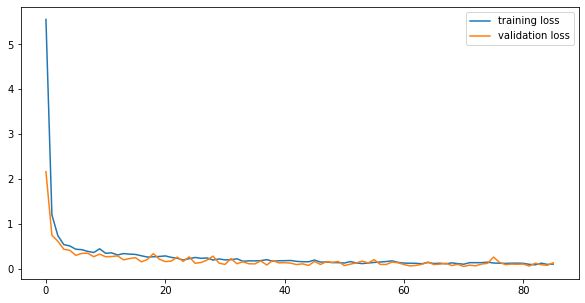

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

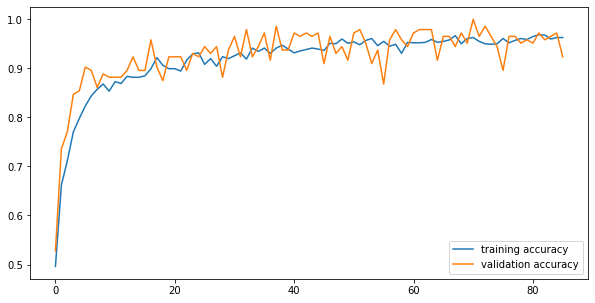

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()
plt.show()

**looking at graphs above it can observed the model is not overfitting**

##### test results

In [ ]:
x_test, y_test = test_data(test_df, pipeline, preprocessing, True)
x_test.shape, y_test.shape

((322, 224, 224, 2), (322, 3))

In [ ]:
# prediction
y_pred = mask_model.predict(x_test)
y_pred.shape

(322, 3)

In [ ]:
# classification report
print(classification_report(y_test.argmax(1), y_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        74
           1       0.99      0.97      0.98       150
           2       1.00      0.98      0.99        98

    accuracy                           0.98       322
   macro avg       0.97      0.98      0.98       322
weighted avg       0.98      0.98      0.98       322



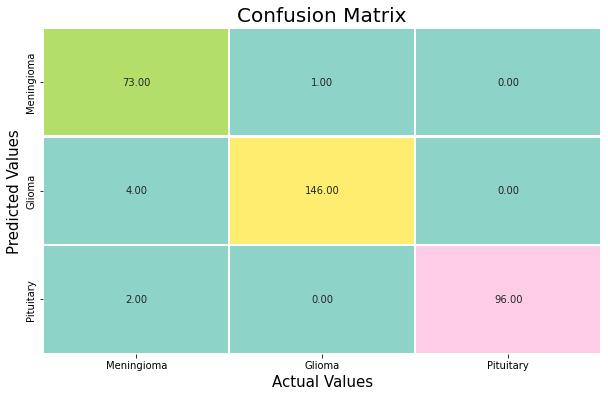

In [ ]:
# confusion matrix

cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))

plt.figure(figsize=(10,6))

sns.heatmap(cm,annot=True,fmt='.2f',cbar=False
            ,xticklabels=['Meningioma','Glioma', 'Pituitary'],
            yticklabels=['Meningioma','Glioma', 'Pituitary'],
            cmap='Set3',linewidths=1.5)

plt.ylabel('Predicted Values',fontsize=15)
plt.xlabel('Actual Values',fontsize=15)
plt.title('Confusion Matrix',fontsize=20)
plt.show()

#### heatmaps

In [ ]:
# salience map
test_image = pipeline(test_df.iloc[0, 0], preprocessing, test_df.iloc[0, 0].replace("image", "mask"))

In [ ]:
# Remove last layer's softmax
mask_model.layers[-1].activation = None

preds = mask_model.predict(np.expand_dims(test_image, 0))

In [ ]:
heatmap = make_gradcam_heatmap(np.expand_dims(test_image, 0), mask_model, "conv_4")

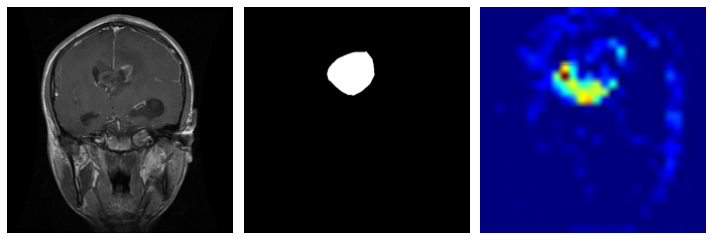

In [ ]:
cam_1 = heatmap_to_img(heatmap)

fig = plt.figure(figsize=(10,10))
axes_1 = fig.add_subplot(131)
plt.imshow(test_image[:, :, 0], cmap="binary_r")
plt.axis("off"
)
axes_2 = fig.add_subplot(132)
plt.imshow(test_image[:, :, 1], cmap="binary_r")
plt.axis("off")

axes_3 = fig.add_subplot(133)
caxes = axes_3.matshow(cam_1)
plt.axis("off")
plt.tight_layout()
# plt.savefig("grad_cam_1.jpg")
plt.show()

### CNN Model 2

In [ ]:
# NO mask model
def cnn_nomask():
  x = keras.layers.Input((224, 224, 1))

  conv_1 = keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu",padding='same', name="conv_1")(x)
  pool_1 = keras.layers.MaxPool2D(2, name="maxpooling_1")(conv_1)

  conv_2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='same', name="conv_2",)(pool_1)
  pool_2 = keras.layers.MaxPool2D(2, name="maxpooling_2")(conv_2)

  conv_3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same', name="conv_3",)(pool_2)
  pool_3 = keras.layers.MaxPool2D(2, name="maxpooling_3")(conv_3)

  conv_4 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same', name="conv_4",)(pool_3)
  
  flatten = keras.layers.Flatten(name="flatten")(conv_4)

  y = keras.layers.Dense(units=3, activation="softmax", name="y")(flatten)

  return keras.models.Model(x, y)

In [ ]:
nomask_model = cnn_nomask()

print(nomask_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 16)      416       
                                                                 
 maxpooling_1 (MaxPooling2D)  (None, 112, 112, 16)     0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 32)      4640      
                                                                 
 maxpooling_2 (MaxPooling2D)  (None, 56, 56, 32)       0         
                                                                 
 conv_3 (Conv2D)             (None, 56, 56, 64)        18496     
                                                                 
 maxpooling_3 (MaxPooling2D)  (None, 28, 28, 64)       0   

#### train validation split

In [ ]:
train_ds = DataGenerator(train_df, 32, True, False, True, preprocessing)
valid_ds = DataGenerator(valid_df, 12, True, False, False, preprocessing)

#### callbacks

In [ ]:
# callback
callbacks_no = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=12, min_lr=0.0001
    ),
    keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/nomasked_cnn_dataLast.h5", save_best_only=True,
                        save_weights_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=15, verbose=0)
]

#### training

In [ ]:
# compile model
nomask_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-04),
                loss=keras.losses.CategoricalCrossentropy(name="loss"),
                metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])

In [ ]:
# training model

nohistory = nomask_model.fit(train_ds, 
                  epochs = 100,
                  steps_per_epoch = 32,
                  validation_data=valid_ds, 
                  validation_steps = 12,
                  callbacks=callbacks_no)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 3.5966 - accuracy: 0.4971
Epoch 1: val_loss improved from inf to 1.36716, saving model to /content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/nomasked_cnn_dataLast.h5
32/32 [==============================] - 11s 350ms/step - loss: 3.5966 - accuracy: 0.4971 - val_loss: 1.3672 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.5635
Epoch 2: val_loss improved from 1.36716 to 0.68477, saving model to /content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/nomasked_cnn_dataLast.h5
32/32 [==============================] - 11s 337ms/step - loss: 0.9862 - accuracy: 0.5635 - val_loss: 0.6848 - val_accuracy: 0.6736 - lr: 1.0000e-04
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.8450 - accuracy: 0.6279
Epoch 3: val_loss did not improve from 0.68477
32/32 [==============================] - 10s 334ms/step - loss: 0.8450 - accur

#### validation

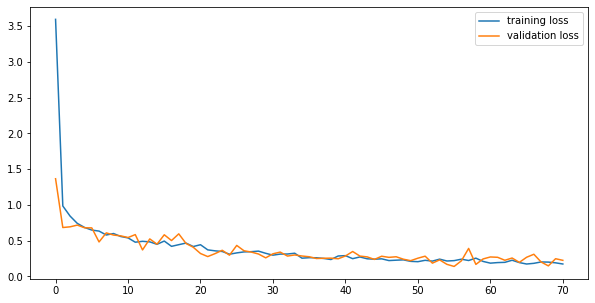

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(nohistory.history['loss'], label="training loss")
plt.plot(nohistory.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

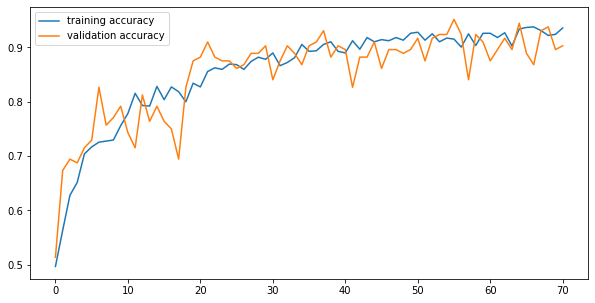

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(nohistory.history['accuracy'], label="training accuracy")
plt.plot(nohistory.history['val_accuracy'], label="validation accuracy")
plt.legend()
plt.show()

**even the model 2 does not seem overfitting**

##### test results

In [ ]:
x_test, y_test = test_data(test_df, pipeline, preprocessing, False)
x_test.shape, y_test.shape

((322, 224, 224, 1), (322, 3))

In [ ]:
# prediction
y_predno = nomask_model.predict(x_test)
y_predno.shape

(322, 3)

In [ ]:
# classification report
print(classification_report(y_test.argmax(1), y_predno.argmax(1)))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84        74
           1       0.92      0.93      0.92       150
           2       0.99      0.97      0.98        98

    accuracy                           0.92       322
   macro avg       0.92      0.91      0.92       322
weighted avg       0.92      0.92      0.92       322



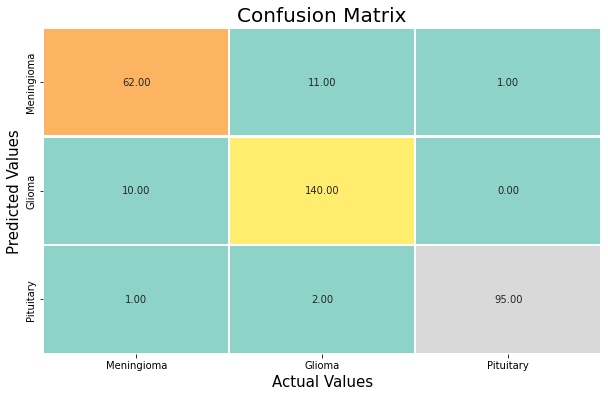

In [ ]:
# confusion matrix

cm = confusion_matrix(y_test.argmax(1), y_predno.argmax(1))

plt.figure(figsize=(10,6))

sns.heatmap(cm,annot=True,fmt='.2f',cbar=False
            ,xticklabels=['Meningioma','Glioma', 'Pituitary'],
            yticklabels=['Meningioma','Glioma', 'Pituitary'],
            cmap='Set3',linewidths=1.5)

plt.ylabel('Predicted Values',fontsize=15)
plt.xlabel('Actual Values',fontsize=15)
plt.title('Confusion Matrix',fontsize=20)
plt.show()

#### heatmaps

In [ ]:
# salience map
test_imageno = pipeline(test_df.iloc[0, 0], preprocessing)

In [ ]:
# Remove last layer's softmax
nomask_model.layers[-1].activation = None

preds = nomask_model.predict(np.expand_dims(test_imageno, 0))

In [ ]:
heatmap = make_gradcam_heatmap(np.expand_dims(test_imageno, 0), nomask_model, "conv_4")

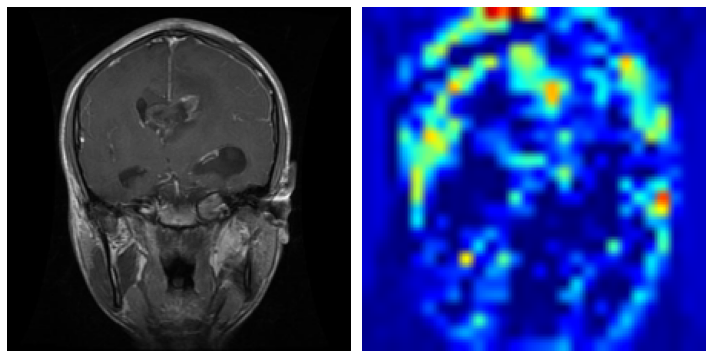

In [ ]:
nocam_1 = heatmap_to_img(heatmap)

fig = plt.figure(figsize=(10,10))
axes_1 = fig.add_subplot(121)
plt.imshow(np.squeeze(test_imageno), cmap="binary_r")
plt.axis("off")
axes_2 = fig.add_subplot(122)
caxes = axes_2.matshow(nocam_1)
plt.axis("off")
plt.tight_layout()
# plt.savefig("grad_cam_1.jpg")
plt.show()

## Conclusion

Even the both models are performing good, looking the heatmaps, we can clearly see that the model 2 is not paying attention on the region of tumor we want.

Whereas the model 1 is paying a good attention to classify the tumor and compartively the accuracy is good than the model 2, this is becauase we are taking advantage of the mask.

**Inorder to make the model explainable the model 1 is selected**

## Futurework

* training a segmentation model to segement the tumor
* than use segemented mask with CNN trained.
* patch image and use mask information to classify the patch (this will eliminate the segmentation task)

In [ ]:
# selecting masked network as final network
def cnn_mask():
  x = keras.layers.Input((224, 224, 2))

  conv_1 = keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu",padding='same', name="conv_1")(x)
  pool_1 = keras.layers.MaxPool2D(2, name="maxpooling_1")(conv_1)

  conv_2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='same', name="conv_2",)(pool_1)
  pool_2 = keras.layers.MaxPool2D(2, name="maxpooling_2")(conv_2)

  conv_3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same', name="conv_3",)(pool_2)
  pool_3 = keras.layers.MaxPool2D(2, name="maxpooling_3")(conv_3)

  conv_4 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same', name="conv_4",)(pool_3)
  
  flatten = keras.layers.Flatten(name="flatten")(conv_4)

  y = keras.layers.Dense(units=3, activation="softmax", name="y")(flatten)

  return keras.models.Model(x, y)

mask_model = cnn_mask()

### Inference

*Assumptions* 

selecting the masked version cnn (model 1), as of now the mask is taken from test set.
But in order to achieve the final inference.
A segementation model will be employed to generate the mask

*assuming the mask is generated here from segementation model(already present mask data)*

In [ ]:
# inference
class Inference:
  def __init__(self, model, weights, use_mask=True):
    """
    Final Inference

    Args:
      model: model to use
      weights: model weights
      use_mask: use mask for masked CNN model, default True
    """
    self.model = model
    self.weights = weights
    self.model.load_weights(self.weights)
    self.use_mask = use_mask
    self.label = {0:"meningioma", 1:"glioma", 2:"pituitary"}


  @classmethod
  def __preprocessing(cls, image, resize=(224, 224)):
    # preprocessing pipeline

    # convert to BW
    image = image.convert("L")

    # resize
    image = image.resize(resize)

    return image


  def __pipeline(self, image, mask_path):
    # final pipeline

    image = Image.open(image)
    image = self.__preprocessing(image)
    image = np.asarray(image)
    image = np.expand_dims(image, 0)

    if self.use_mask:
      mask = Image.open(mask_path)
      
      mask = self.__preprocessing(mask)

      mask = np.asarray(mask)

      mask = np.expand_dims(mask, 0)
      image = np.vstack((image, mask))

    return image.T

  def classify_tumor(self, image, mask_path):
    """
    Classifies the type of tumor.

    Args:
      image: image to classify
      mask_path: generated mask from segmentation model

    Returns:
      predictions dict with probabilities
    """
    # mask_path from segementation model (assumption)
    # data preprocessing pipeline

    image = self.__pipeline(image, mask_path)

    image = np.expand_dims(image, 0)

    confidences = self.model.predict(image)
    confidences = confidences.ravel()
    prediction = {self.label[i]: float(confidences[i]) for i in range(len(confidences))}

    return prediction

In [ ]:
# API
API = Inference(mask_model, "/content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/masked_cnn_dataLast.h5", True)

In [ ]:
# call predictions
out = API.classify_tumor(test_df.iloc[0, 0], test_df.iloc[0, 0].replace("image", "mask"))

In [ ]:
out

{'glioma': 0.9965421557426453,
 'meningioma': 0.003208658192306757,
 'pituitary': 0.0002491511113476008}

### Heatmaps

selected model 1 the heatmaps generated can be validated with the grouth truth masks

In [ ]:
mask_model.load_weights("/content/drive/MyDrive/BrainsightAI/Weights/BrainTumor/masked_cnn_dataLast.h5")

In [ ]:
test_image_1 = pipeline(test_df.iloc[318, 0], preprocessing, test_df.iloc[318, 0].replace("image", "mask")) # 2
test_image_2 = pipeline(test_df.iloc[0, 0], preprocessing, test_df.iloc[0, 0].replace("image", "mask")) # 1
test_image_3 = pipeline(test_df.iloc[317, 0], preprocessing, test_df.iloc[317, 0].replace("image", "mask")) #0

In [ ]:
# Heatmaps
def get_grad(image, model):
  """
  Plots heat with ground truth

  Args:
    image: image set
    model: model to perform the gradcam
  Returns:
    matplotlib plot
  """

  label = {0:"meningioma", 1:"glioma", 2:"pituitary"}

  confidences = model.predict(np.expand_dims(image, 0))
  confidences = confidences.ravel()
  prediction = {label[i]: float(confidences[i]) for i in range(len(confidences))}

  print(f"predictions: {prediction}\n")

  heatmap = make_gradcam_heatmap(np.expand_dims(image, 0), mask_model, "conv_4")

  cam_1 = heatmap_to_img(heatmap)

  fig = plt.figure(figsize=(10,10))
  axes_1 = fig.add_subplot(131)
  plt.imshow(image[:, :, 0], cmap="binary_r")
  plt.axis("off"
  )
  axes_2 = fig.add_subplot(132)
  plt.imshow(image[:, :, 1], cmap="binary_r")
  plt.axis("off")

  axes_3 = fig.add_subplot(133)
  caxes = axes_3.matshow(cam_1)
  plt.axis("off")
  plt.tight_layout()
  # plt.savefig("grad_cam_1.jpg")
  plt.show()

predictions: {'meningioma': 0.0021161322947591543, 'glioma': 0.00025022614863701165, 'pituitary': 0.9976335763931274}



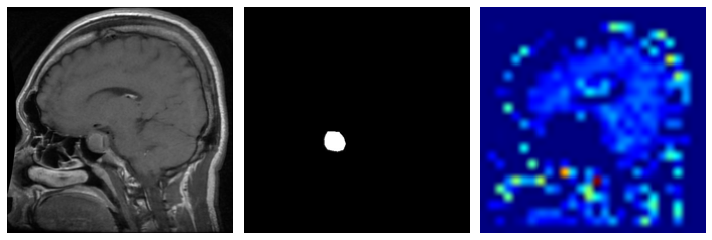

In [ ]:
get_grad(test_image_1, mask_model)

predictions: {'meningioma': 0.003208658192306757, 'glioma': 0.9965421557426453, 'pituitary': 0.0002491511113476008}



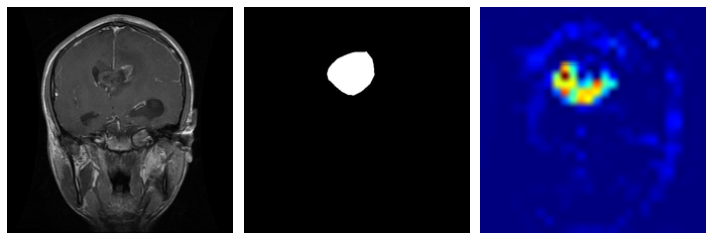

In [ ]:
get_grad(test_image_2, mask_model)

predictions: {'meningioma': 0.998928964138031, 'glioma': 0.0010598305379971862, 'pituitary': 1.1136965440528002e-05}



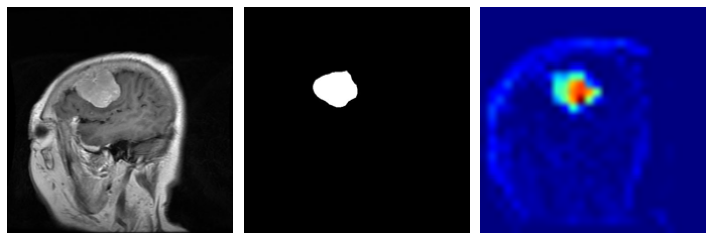

In [ ]:
get_grad(test_image_3, mask_model)

## References

* https://figshare.com/articles/dataset/brain_tumor_dataset/1512427
* https://keras.io/examples/vision/grad_cam/